# Load topographic maps for all subjects

In [1]:
#-------------------------------------------------------------------------------
FILEID = "12Atu_t9xpPChdd1hhKNv2RCiyAVdyUud"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O GIGAnew_data_all_sbjs.zip && rm -rf /tmp/cookies.txt
!unzip GIGAnew_data_all_sbjs.zip
!dir
!pip install mne==0.19
#-------------------------------------------------------------------------------

--2021-06-24 03:15:03--  https://docs.google.com/uc?export=download&confirm=nUDh&id=12Atu_t9xpPChdd1hhKNv2RCiyAVdyUud
Resolving docs.google.com (docs.google.com)... 74.125.195.113, 74.125.195.102, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-6o-docs.googleusercontent.com/docs/securesc/kq4e0srpa423enu0q0mr6r7p8is5gjlc/ap73oss1sscq0bpv9rtl9scn9s0o1517/1624504500000/00053843418029901611/00818257281405816367Z/12Atu_t9xpPChdd1hhKNv2RCiyAVdyUud?e=download [following]
--2021-06-24 03:15:03--  https://doc-0g-6o-docs.googleusercontent.com/docs/securesc/kq4e0srpa423enu0q0mr6r7p8is5gjlc/ap73oss1sscq0bpv9rtl9scn9s0o1517/1624504500000/00053843418029901611/00818257281405816367Z/12Atu_t9xpPChdd1hhKNv2RCiyAVdyUud?e=download
Resolving doc-0g-6o-docs.googleusercontent.com (doc-0g-6o-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting

# Load supporting modules

In [2]:
#-------------------------------------------------------------------------------
import numpy as np
import scipy.io as sio
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import math
import shutil
import pickle
import os
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,cohen_kappa_score,mean_squared_error
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from datetime import date, datetime
from scipy.stats import kurtosis, skew
from sklearn.model_selection import ShuffleSplit
from time import time
#-------------------------------------------------------------------------------

# Define custom functions to use
- We design three custom functions: i) load data acroos time windows, ii) normalization function, and iii) function to build the CNN network

In [3]:
#-------------------------------------------------------------------------------
def TW_data(sbj,time_inf,time_sup):
    # Load data/images----------------------------------------------------------
    path_cwt = 'CWT_CSP_data_mubeta_8_30_Tw_'+str(time_inf)+'s_'+str(time_sup)+'s_subject'+str(sbj)+'_cwt_resized_10.pickle'  
    with open(path_cwt, 'rb') as f:
         X_train_re_cwt, X_test_re_cwt, y_train, y_test = pickle.load(f)
    path_csp = 'CWT_CSP_data_mubeta_8_30_Tw_'+str(time_inf)+'s_'+str(time_sup)+'s_subject'+str(sbj)+'_csp_resized_10.pickle'  
    with open(path_csp, 'rb') as f:
         X_train_re_csp, X_test_re_csp, y_train, y_test = pickle.load(f)
    #---------------------------------------------------------------------------
    return X_train_re_cwt, X_train_re_csp, X_test_re_cwt, X_test_re_csp, y_train, y_test
#-------------------------------------------------------------------------------
def norm_data(XF_train_cwt, XF_train_csp, XF_test_cwt, XF_test_csp, n_fb, Ntw, y_train, y_test):
    # orden de las inputs:
    # [CWT_fb1_TW1, CWT_fb2_TW1 --- CWT_fb1_TW2, CWT_fb2_TW2 --- CWT_fb1_TWN, CWT_fb2_TWN] ... [CSP]
    #---------------------------------------------------------------------------
    XT_train_csp = []
    XT_valid_csp = []
    XT_test_csp  = []
    XT_train_cwt = []
    XT_valid_cwt = []
    XT_test_cwt  = []
    for tw in range(Ntw):
        for fb in range(n_fb):
            X_train_cwt, X_test_cwt = XF_train_cwt[tw][:,fb,:,:].astype(np.uint8), XF_test_cwt[tw][:,fb,:,:].astype(np.uint8)
            X_train_csp, X_test_csp = XF_train_csp[tw][:,fb,:,:].astype(np.uint8), XF_test_csp[tw][:,fb,:,:].astype(np.uint8)
            #-------------------------------------------------------------------
            # train/validation data split
            rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)
            for train_index, valid_index in rs.split(X_train_cwt):
              X_train_cwtf = X_train_cwt[train_index,:,:] # cwt
              X_valid_cwtf = X_train_cwt[valid_index,:,:]
              X_train_cspf = X_train_csp[train_index,:,:] # csp
              X_valid_cspf = X_train_csp[valid_index,:,:]
            #-------------------------------------------------------------------          
            # Normalize data----------------------------------------------------
            X_mean_cwt  = X_train_cwtf.mean(axis=0, keepdims=True)
            X_std_cwt   = X_train_cwtf.std(axis=0, keepdims=True) + 1e-7
            X_train_cwt = (X_train_cwtf - X_mean_cwt) / X_std_cwt
            X_valid_cwt = (X_valid_cwtf - X_mean_cwt) / X_std_cwt
            X_test_cwt  = (X_test_cwt  - X_mean_cwt) / X_std_cwt
                                
            X_mean_csp  = X_train_cspf.mean(axis=0, keepdims=True)
            X_std_csp   = X_train_cspf.std(axis=0, keepdims=True) + 1e-7
            X_train_csp = (X_train_cspf - X_mean_csp) / X_std_csp
            X_valid_csp = (X_valid_cspf - X_mean_csp) / X_std_csp
            X_test_csp  = (X_test_csp  - X_mean_csp) / X_std_csp
            #-------------------------------------------------------------------
            # set new axis------------------------------------------------------
            X_train_cwt = X_train_cwt[..., np.newaxis]
            X_valid_cwt = X_valid_cwt[..., np.newaxis]
            X_test_cwt  = X_test_cwt[..., np.newaxis]   
            XT_train_cwt.append(X_train_cwt)
            XT_valid_cwt.append(X_valid_cwt)
            XT_test_cwt.append(X_test_cwt)
                                
            X_train_csp = X_train_csp[..., np.newaxis]
            X_valid_csp = X_valid_csp[..., np.newaxis]
            X_test_csp  = X_test_csp[..., np.newaxis]   
            XT_train_csp.append(X_train_csp)
            XT_valid_csp.append(X_valid_csp)
            XT_test_csp.append(X_test_csp)
            #-------------------------------------------------------------------
    y_trainf = y_train[train_index]
    y_validf = y_train[valid_index]
    y_trainF, y_validF, y_testF = y_trainf.reshape((-1,))-1, y_validf.reshape((-1,))-1, y_test.reshape((-1,))-1
    #---------------------------------------------------------------------------
    # Convert class vectors to binary class matrices----------------------------
    y_train = keras.utils.to_categorical(y_trainF,num_classes)
    y_valid = keras.utils.to_categorical(y_validF,num_classes)
    y_test  = keras.utils.to_categorical(y_testF,num_classes)
    #---------------------------------------------------------------------------
    XT_train = XT_train_cwt + XT_train_csp
    XT_valid = XT_valid_cwt + XT_valid_csp
    XT_test  = XT_test_cwt  + XT_test_csp
    #---------------------------------------------------------------------------
    return XT_train, XT_valid, XT_test, y_train, y_valid, y_test, train_index, valid_index  
#-------------------------------------------------------------------------------
def cnn_network(n_fb,Nkfeats,Ntw,shape_,n_filt,units,l1p,l2p,lrate,sbj):
    #---------------------------------------------------------------------------
    keras.backend.clear_session()
    np.random.seed(123)
    tf.compat.v1.random.set_random_seed(123)
    #---------------------------------------------------------------------------
    input_  = [None]*Ntw*n_fb*Nkfeats
    conv_   = [None]*Ntw*n_fb*Nkfeats
    pool_   = [None]*Ntw*n_fb*Nkfeats
    batch0_ = [None]*Ntw*n_fb*Nkfeats
    batch2_ = [None]*Ntw*n_fb*Nkfeats
    for i in range(Ntw*n_fb*Nkfeats):
        input_[i]  = keras.layers.Input(shape=[shape_,shape_,1])
        conv_[i]   = keras.layers.Conv2D(filters=n_filt,kernel_size=3,strides=1,activation='relu',padding='SAME',input_shape=[shape_,shape_,1])(input_[i])
        #-----------------------------------------------------------------------
        batch0_[i] = keras.layers.BatchNormalization()(conv_[i])
        #-----------------------------------------------------------------------
        pool_[i]   = keras.layers.MaxPooling2D(pool_size=2)(batch0_[i])
    concat  = keras.layers.concatenate(pool_)
    flat    = keras.layers.Flatten()(concat)
    #---------------------------------------------------------------------------
    batch1  = keras.layers.BatchNormalization()(flat)
    hidden1 = keras.layers.Dense(units=units,activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=l1p, l2=l2p), kernel_constraint=max_norm(1.))(batch1)#
    batch2  = keras.layers.BatchNormalization()(hidden1)
    output  = keras.layers.Dense(units=2, activation='softmax', kernel_constraint=max_norm(1.))(batch2)#
    model   = keras.models.Model(inputs=input_, outputs=[output])
    
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(lrate, 4000, power=1.0,cycle=False, name=None)
    opt     = keras.optimizers.Adam(learning_rate=learning_rate_fn) 
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    return model
#-------------------------------------------------------------------------------

# Creating results and parameter setting folders
- In folder results we store the performance values in format .mat
- In folder parameter_setting we store the model' weights in format .hdf5 per fold.

In [4]:
#-------------------------------------------------------------------------------
try:
  os.mkdir('results')
except:
  print("Exist folder!")
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
try:
  os.mkdir('train_valid_idxs')
except:
  print("Exist folder!")
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
try:
  os.mkdir('parameter_setting')
except:
  print("Exist folder!")
#-------------------------------------------------------------------------------

# DWCNN training, validation and test stage
In this example, we consider one fold training and validation.

In [5]:
# Some initial parameters-------------------------------------------------------
sbj           = [14,3,41,28] # subject id
n_fb          = 2                              # 0 --> 8-12Hz, 1--->12-30Hz
num_classes   = 2                              # num of classes
n_filt        = 2                              # number of CNN filters
n_unit        = [100,200,300]                  # number of hidden units in hidden layer
learning_rate = 1e-4                           # learning rate value
l1_param      = [0.0005,0.001,0.005]           # l_1 regularization param
l2_param      = [0.0005,0.001,0.005]           # L_2 regularization param
Ntw           = 5                              # number of time windows
acc_test      = []                             # store variable of acc validation
Nkfeats       = 2                              # number of feat types
#-------------------------------------------------------------------------------
# load data train/test trough all tw
th_name  = np.array([[-1.5, 0.5],[-0.5, 1.5],[0.5, 2.5],[1.5, 3.5],[2.5, 4.5]]) # considered time-windows
XT_train_group = []
XT_valid_group = []
XT_test_group  = []
y_train_group  = []
y_valid_group  = []
y_test_group   = []
train_index_group = []
valid_index_group = []
for k in range(len(sbj)):
  XF_train_cwt = []
  XF_train_csp = []
  XF_test_cwt  = []
  XF_test_csp  = []
  for i in range(th_name.shape[0]):
    X_train_re_cwt, X_train_re_csp, X_test_re_cwt, X_test_re_csp, y_trainF, y_testF = TW_data(sbj[k],th_name[i,0],th_name[i,1])
    XF_train_cwt.append(X_train_re_cwt)
    XF_train_csp.append(X_train_re_csp)
    XF_test_cwt.append(X_test_re_cwt)
    XF_test_csp.append(X_test_re_csp)
  # adjust data
  XT_train, XT_valid, XT_test, y_train, y_valid, y_test, train_index, valid_index = norm_data(XF_train_cwt, XF_train_csp, XF_test_cwt, XF_test_csp, n_fb, Ntw, y_trainF, y_testF)
  XT_train_group.append(XT_train)
  XT_valid_group.append(XT_valid)
  XT_test_group.append(XT_test)
  y_train_group.append(y_train)
  y_valid_group.append(y_valid)
  y_test_group.append(y_test)
  train_index_group.append(train_index)
  valid_index_group.append(valid_index)
#-------------------------------------------------------------------------------
XT_train_group_fT = []
XT_valid_group_fT = []
XT_test_group_fT  = []
y_train_group_f   = []
y_valid_group_f   = []
y_test_group_f    = []
for l in range(len(XT_train_group[0])):
  XT_train_group_f  = []
  XT_valid_group_f  = []
  XT_test_group_f   = []
  for m in range(len(XT_train_group)):
    XT_train_group_f.append(XT_train_group[m][l])
    XT_valid_group_f.append(XT_valid_group[m][l])
    XT_test_group_f.append(XT_test_group[m][l])

    if l==0:
      y_train_group_f.append(y_train_group[m])  
      y_valid_group_f.append(y_valid_group[m])
      y_test_group_f.append(y_test_group[m])

  XT_train_group_fT.append(np.concatenate(XT_train_group_f,axis=0))
  XT_valid_group_fT.append(np.concatenate(XT_valid_group_f,axis=0))
  XT_test_group_fT.append(np.concatenate(XT_test_group_f,axis=0))

y_train_group_fT = np.concatenate(y_train_group_f,axis=0)
y_valid_group_fT = np.concatenate(y_valid_group_f,axis=0)
y_test_group_fT  = np.concatenate(y_test_group_f,axis=0)

train_index_group_fT = np.concatenate(train_index_group)
valid_index_group_fT = np.concatenate(valid_index_group)

print('Train: ',XT_train_group_fT[0].shape,y_train_group_fT.shape,train_index_group_fT.shape)
print('Valid: ',XT_valid_group_fT[0].shape,y_valid_group_fT.shape,valid_index_group_fT.shape)
print('Test: ',XT_test_group_fT[0].shape,y_test_group_fT.shape)
#-------------------------------------------------------------------------------
with open('train_valid_idxs/tr_vld_idxs_sbj_'+str(sbj)+'.pickle', 'wb') as f:
  pickle.dump([train_index_group_fT, valid_index_group_fT], f)
#-------------------------------------------------------------------------------

Train:  (642, 40, 40, 1) (642, 2) (642,)
Valid:  (72, 40, 40, 1) (72, 2) (72,)
Test:  (80, 40, 40, 1) (80, 2)


Epoch 1/200
3/3 - 34s - loss: 6.7016 - accuracy: 0.5717 - val_loss: 5.6262 - val_accuracy: 0.6944

Epoch 00001: val_accuracy improved from -inf to 0.69444, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 5.4552 - accuracy: 0.8692 - val_loss: 5.4311 - val_accuracy: 0.7639

Epoch 00002: val_accuracy improved from 0.69444 to 0.76389, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.0005.hdf5
Epoch 3/200
3/3 - 0s - loss: 5.2388 - accuracy: 0.9517 - val_loss: 5.2583 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.76389 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.0005.hdf5
Epoch 4/200
3/3 - 0s - loss: 5.0498 - accuracy: 0.9875 - val_loss: 5.0868 - val_accuracy: 0.7917

Epoch 00004: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.0005.hdf

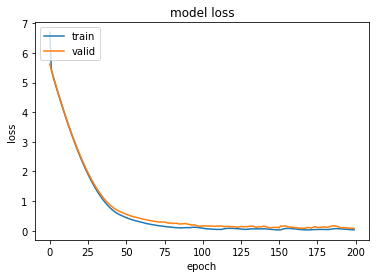

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 6.7712 - accuracy: 0.5717 - val_loss: 5.6746 - val_accuracy: 0.6944

Epoch 00001: val_accuracy improved from -inf to 0.69444, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 5.5029 - accuracy: 0.8692 - val_loss: 5.4771 - val_accuracy: 0.7639

Epoch 00002: val_accuracy improved from 0.69444 to 0.76389, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.001.hdf5
Epoch 3/200
3/3 - 0s - loss: 5.2841 - accuracy: 0.9533 - val_loss: 5.3018 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.76389 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.001.hdf5
Epoch 4/200
3/3 - 0s - loss: 5.0926 - accuracy: 0.9875 - val_loss: 5.1279 - val_accuracy: 0.7917

Epoch 00004: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.001.hdf5
Epo

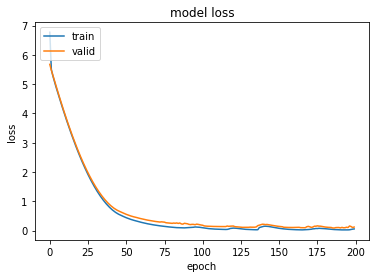

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 7.3274 - accuracy: 0.5717 - val_loss: 6.0614 - val_accuracy: 0.6806

Epoch 00001: val_accuracy improved from -inf to 0.68056, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 5.8846 - accuracy: 0.8692 - val_loss: 5.8441 - val_accuracy: 0.7639

Epoch 00002: val_accuracy improved from 0.68056 to 0.76389, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.005.hdf5
Epoch 3/200
3/3 - 0s - loss: 5.6461 - accuracy: 0.9517 - val_loss: 5.6492 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.76389 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.005.hdf5
Epoch 4/200
3/3 - 0s - loss: 5.4351 - accuracy: 0.9875 - val_loss: 5.4562 - val_accuracy: 0.7917

Epoch 00004: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.0005_l2_0.005.hdf5
Epo

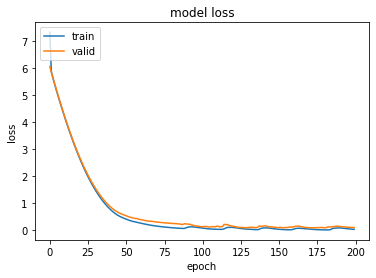

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 13.0552 - accuracy: 0.5685 - val_loss: 10.9665 - val_accuracy: 0.6806

Epoch 00001: val_accuracy improved from -inf to 0.68056, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 10.7457 - accuracy: 0.8645 - val_loss: 10.5774 - val_accuracy: 0.7639

Epoch 00002: val_accuracy improved from 0.68056 to 0.76389, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.0005.hdf5
Epoch 3/200
3/3 - 0s - loss: 10.3348 - accuracy: 0.9502 - val_loss: 10.2087 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.76389 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.0005.hdf5
Epoch 4/200
3/3 - 0s - loss: 9.9494 - accuracy: 0.9860 - val_loss: 9.8414 - val_accuracy: 0.7917

Epoch 00004: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.0005.hd

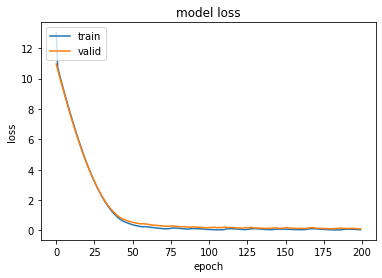

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 13.1248 - accuracy: 0.5685 - val_loss: 11.0147 - val_accuracy: 0.6806

Epoch 00001: val_accuracy improved from -inf to 0.68056, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 10.7932 - accuracy: 0.8645 - val_loss: 10.6228 - val_accuracy: 0.7639

Epoch 00002: val_accuracy improved from 0.68056 to 0.76389, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.001.hdf5
Epoch 3/200
3/3 - 0s - loss: 10.3796 - accuracy: 0.9517 - val_loss: 10.2515 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.76389 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.001.hdf5
Epoch 4/200
3/3 - 0s - loss: 9.9916 - accuracy: 0.9860 - val_loss: 9.8816 - val_accuracy: 0.7917

Epoch 00004: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.001.hdf5
E

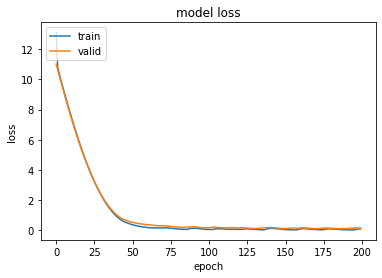

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 13.6809 - accuracy: 0.5685 - val_loss: 11.4001 - val_accuracy: 0.6944

Epoch 00001: val_accuracy improved from -inf to 0.69444, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 11.1731 - accuracy: 0.8645 - val_loss: 10.9864 - val_accuracy: 0.7639

Epoch 00002: val_accuracy improved from 0.69444 to 0.76389, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.005.hdf5
Epoch 3/200
3/3 - 0s - loss: 10.7376 - accuracy: 0.9502 - val_loss: 10.5936 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.76389 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.001_l2_0.005.hdf5
Epoch 4/200
3/3 - 0s - loss: 10.3281 - accuracy: 0.9844 - val_loss: 10.2027 - val_accuracy: 0.7778

Epoch 00004: val_accuracy did not improve from 0.77778
Epoch 5/200
3/3 - 0s - loss: 9.9327 - accuracy: 0.9875 - val_loss: 9.8130 - val_accuracy: 0.805

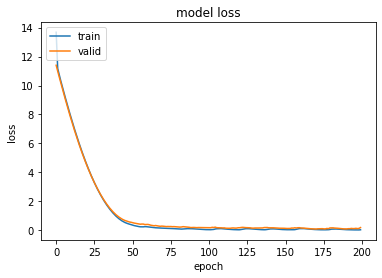

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 63.8618 - accuracy: 0.5389 - val_loss: 53.4855 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 52.8073 - accuracy: 0.7835 - val_loss: 51.2969 - val_accuracy: 0.7500

Epoch 00002: val_accuracy improved from 0.62500 to 0.75000, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.0005.hdf5
Epoch 3/200
3/3 - 0s - loss: 50.6049 - accuracy: 0.8754 - val_loss: 49.1530 - val_accuracy: 0.8056

Epoch 00003: val_accuracy improved from 0.75000 to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.0005.hdf5
Epoch 4/200
3/3 - 0s - loss: 48.4476 - accuracy: 0.9377 - val_loss: 47.0451 - val_accuracy: 0.8056

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 46.3367 - accuracy: 0.9564 - val_loss: 44.9742 - val_accuracy: 

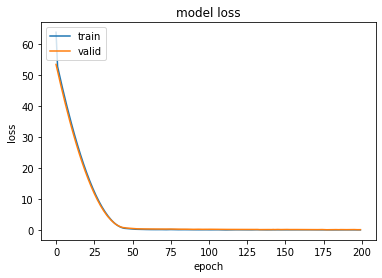

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 63.9313 - accuracy: 0.5389 - val_loss: 53.5334 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 52.8544 - accuracy: 0.7835 - val_loss: 51.3417 - val_accuracy: 0.7500

Epoch 00002: val_accuracy improved from 0.62500 to 0.75000, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.001.hdf5
Epoch 3/200
3/3 - 0s - loss: 50.6489 - accuracy: 0.8754 - val_loss: 49.1948 - val_accuracy: 0.8056

Epoch 00003: val_accuracy improved from 0.75000 to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.001.hdf5
Epoch 4/200
3/3 - 0s - loss: 48.4887 - accuracy: 0.9361 - val_loss: 47.0842 - val_accuracy: 0.8056

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 46.3750 - accuracy: 0.9564 - val_loss: 45.0106 - val_accuracy: 0.8

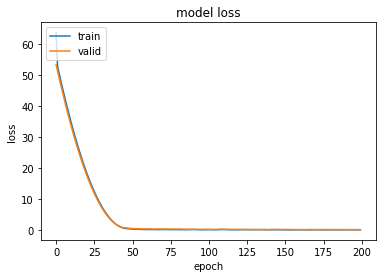

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 64.4874 - accuracy: 0.5389 - val_loss: 53.9164 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 53.2311 - accuracy: 0.7835 - val_loss: 51.7000 - val_accuracy: 0.7500

Epoch 00002: val_accuracy improved from 0.62500 to 0.75000, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.005.hdf5
Epoch 3/200
3/3 - 0s - loss: 51.0012 - accuracy: 0.8754 - val_loss: 49.5295 - val_accuracy: 0.8056

Epoch 00003: val_accuracy improved from 0.75000 to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_100_l1_0.005_l2_0.005.hdf5
Epoch 4/200
3/3 - 0s - loss: 48.8177 - accuracy: 0.9346 - val_loss: 47.3965 - val_accuracy: 0.8056

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 46.6819 - accuracy: 0.9564 - val_loss: 45.3018 - val_accuracy: 0.8

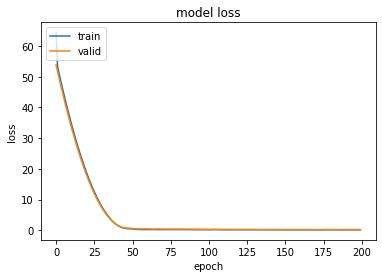

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 13.1021 - accuracy: 0.6028 - val_loss: 11.0105 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.0005_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 10.7962 - accuracy: 0.8941 - val_loss: 10.6458 - val_accuracy: 0.7917

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 10.4027 - accuracy: 0.9502 - val_loss: 10.2986 - val_accuracy: 0.7778

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 10.0324 - accuracy: 0.9860 - val_loss: 9.9422 - val_accuracy: 0.7639

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 9.6759 - accuracy: 0.9922 - val_loss: 9.5858 - val_accuracy: 0.7778

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 9.3251 - accuracy: 0.9984 - val_loss: 9.2325 - val_accuracy: 0.7917

Epoch 00006: val_accuracy did not i

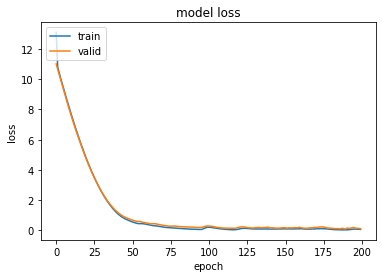

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 13.2406 - accuracy: 0.6028 - val_loss: 11.1071 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.0005_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 10.8914 - accuracy: 0.8941 - val_loss: 10.7371 - val_accuracy: 0.7917

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 10.4927 - accuracy: 0.9502 - val_loss: 10.3848 - val_accuracy: 0.7778

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 10.1173 - accuracy: 0.9860 - val_loss: 10.0234 - val_accuracy: 0.7639

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 9.7557 - accuracy: 0.9922 - val_loss: 9.6621 - val_accuracy: 0.7778

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 9.4000 - accuracy: 0.9984 - val_loss: 9.3040 - val_accuracy: 0.7917

Epoch 00006: val_accuracy did not i

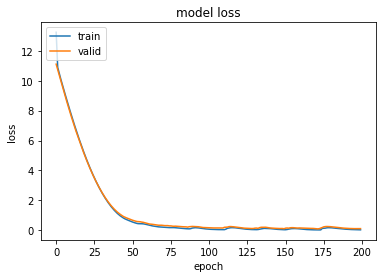

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 14.3490 - accuracy: 0.6012 - val_loss: 11.8792 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.0005_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 11.6524 - accuracy: 0.8925 - val_loss: 11.4670 - val_accuracy: 0.7917

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 11.2115 - accuracy: 0.9502 - val_loss: 11.0729 - val_accuracy: 0.7778

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 10.7946 - accuracy: 0.9860 - val_loss: 10.6708 - val_accuracy: 0.7639

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 10.3924 - accuracy: 0.9907 - val_loss: 10.2698 - val_accuracy: 0.7917

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 9.9972 - accuracy: 0.9969 - val_loss: 9.8733 - val_accuracy: 0.7917

Epoch 00006: val_accuracy did not

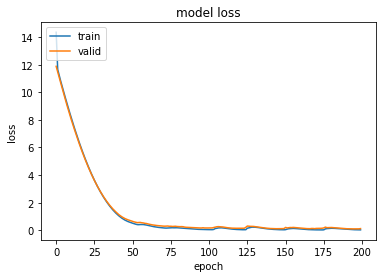

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 25.7872 - accuracy: 0.6028 - val_loss: 21.6753 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.001_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 21.3535 - accuracy: 0.8832 - val_loss: 20.8981 - val_accuracy: 0.8056

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 20.5466 - accuracy: 0.9502 - val_loss: 20.1362 - val_accuracy: 0.7778

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 19.7628 - accuracy: 0.9829 - val_loss: 19.3689 - val_accuracy: 0.7639

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 18.9934 - accuracy: 0.9907 - val_loss: 18.6041 - val_accuracy: 0.7917

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 18.2334 - accuracy: 0.9938 - val_loss: 17.8467 - val_accuracy: 0.8333

Epoch 00006: val_accuracy impro

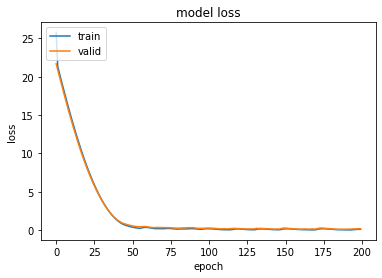

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 25.9257 - accuracy: 0.6028 - val_loss: 21.7714 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.001_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 21.4482 - accuracy: 0.8832 - val_loss: 20.9885 - val_accuracy: 0.8056

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 20.6355 - accuracy: 0.9517 - val_loss: 20.2209 - val_accuracy: 0.7778

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 19.8461 - accuracy: 0.9829 - val_loss: 19.4482 - val_accuracy: 0.7639

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 19.0712 - accuracy: 0.9907 - val_loss: 18.6781 - val_accuracy: 0.7917

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 18.3060 - accuracy: 0.9938 - val_loss: 17.9156 - val_accuracy: 0.8333

Epoch 00006: val_accuracy improv

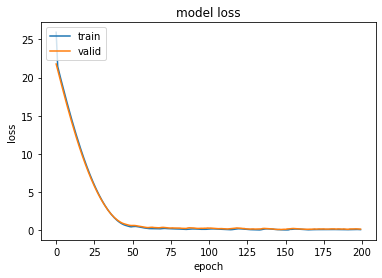

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 27.0338 - accuracy: 0.6028 - val_loss: 22.5405 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.001_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 22.2052 - accuracy: 0.8832 - val_loss: 21.7111 - val_accuracy: 0.8056

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 21.3463 - accuracy: 0.9517 - val_loss: 20.8982 - val_accuracy: 0.7778

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 20.5119 - accuracy: 0.9829 - val_loss: 20.0819 - val_accuracy: 0.7639

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 19.6935 - accuracy: 0.9891 - val_loss: 19.2698 - val_accuracy: 0.7917

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 18.8864 - accuracy: 0.9938 - val_loss: 18.4669 - val_accuracy: 0.8333

Epoch 00006: val_accuracy improv

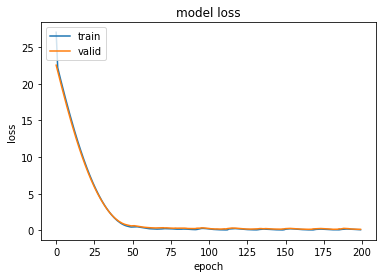

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 127.2228 - accuracy: 0.5592 - val_loss: 106.6331 - val_accuracy: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 105.3457 - accuracy: 0.8100 - val_loss: 102.1786 - val_accuracy: 0.8194

Epoch 00002: val_accuracy improved from 0.75000 to 0.81944, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.0005.hdf5
Epoch 3/200
3/3 - 0s - loss: 100.8828 - accuracy: 0.8972 - val_loss: 97.8063 - val_accuracy: 0.8750

Epoch 00003: val_accuracy improved from 0.81944 to 0.87500, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.0005.hdf5
Epoch 4/200
3/3 - 0s - loss: 96.5081 - accuracy: 0.9252 - val_loss: 93.5174 - val_accuracy: 0.8611

Epoch 00004: val_accuracy did not improve from 0.87500
Epoch 5/200
3/3 - 0s - loss: 92.2271 - accuracy: 0.9548 - val_loss: 89.3147 - val_accur

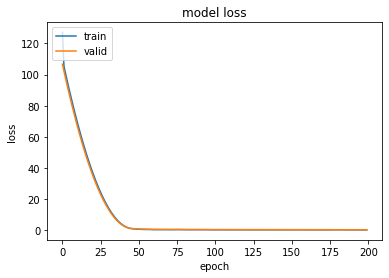

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 127.3613 - accuracy: 0.5592 - val_loss: 106.7288 - val_accuracy: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 105.4398 - accuracy: 0.8100 - val_loss: 102.2681 - val_accuracy: 0.8194

Epoch 00002: val_accuracy improved from 0.75000 to 0.81944, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.001.hdf5
Epoch 3/200
3/3 - 0s - loss: 100.9707 - accuracy: 0.8956 - val_loss: 97.8900 - val_accuracy: 0.8750

Epoch 00003: val_accuracy improved from 0.81944 to 0.87500, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.001.hdf5
Epoch 4/200
3/3 - 0s - loss: 96.5903 - accuracy: 0.9252 - val_loss: 93.5955 - val_accuracy: 0.8611

Epoch 00004: val_accuracy did not improve from 0.87500
Epoch 5/200
3/3 - 0s - loss: 92.3037 - accuracy: 0.9548 - val_loss: 89.3875 - val_accuracy

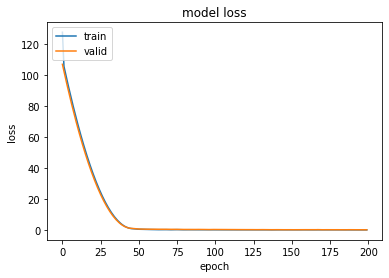

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 128.4692 - accuracy: 0.5592 - val_loss: 107.4943 - val_accuracy: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 106.1922 - accuracy: 0.8069 - val_loss: 102.9840 - val_accuracy: 0.8194

Epoch 00002: val_accuracy improved from 0.75000 to 0.81944, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.005.hdf5
Epoch 3/200
3/3 - 0s - loss: 101.6742 - accuracy: 0.8956 - val_loss: 98.5588 - val_accuracy: 0.8750

Epoch 00003: val_accuracy improved from 0.81944 to 0.87500, saving model to parameter_setting/weights_group_filters_2_units_200_l1_0.005_l2_0.005.hdf5
Epoch 4/200
3/3 - 0s - loss: 97.2473 - accuracy: 0.9252 - val_loss: 94.2197 - val_accuracy: 0.8611

Epoch 00004: val_accuracy did not improve from 0.87500
Epoch 5/200
3/3 - 0s - loss: 92.9167 - accuracy: 0.9548 - val_loss: 89.9696 - val_accuracy

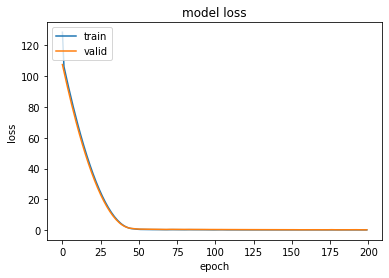

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 19.4779 - accuracy: 0.6121 - val_loss: 16.3994 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.0005_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 16.1097 - accuracy: 0.9315 - val_loss: 15.8468 - val_accuracy: 0.7361

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 15.5329 - accuracy: 0.9688 - val_loss: 15.3088 - val_accuracy: 0.7083

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 14.9688 - accuracy: 0.9907 - val_loss: 14.7452 - val_accuracy: 0.7222

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 14.4148 - accuracy: 0.9938 - val_loss: 14.1860 - val_accuracy: 0.7500

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 13.8655 - accuracy: 0.9953 - val_loss: 13.6336 - val_accuracy: 0.7778

Epoch 00006: val_accuracy did 

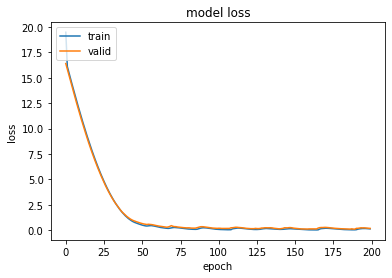

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 19.6850 - accuracy: 0.6121 - val_loss: 16.5440 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.0005_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 16.2521 - accuracy: 0.9315 - val_loss: 15.9831 - val_accuracy: 0.7361

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 15.6671 - accuracy: 0.9688 - val_loss: 15.4370 - val_accuracy: 0.7083

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 15.0950 - accuracy: 0.9907 - val_loss: 14.8656 - val_accuracy: 0.7222

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 14.5330 - accuracy: 0.9938 - val_loss: 14.2987 - val_accuracy: 0.7500

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 13.9761 - accuracy: 0.9953 - val_loss: 13.7389 - val_accuracy: 0.7778

Epoch 00006: val_accuracy did n

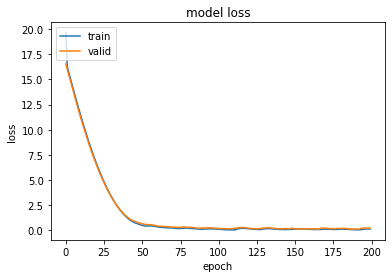

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 21.3414 - accuracy: 0.6106 - val_loss: 17.7004 - val_accuracy: 0.8056

Epoch 00001: val_accuracy improved from -inf to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.0005_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 17.3909 - accuracy: 0.9283 - val_loss: 17.0727 - val_accuracy: 0.7361

Epoch 00002: val_accuracy did not improve from 0.80556
Epoch 3/200
3/3 - 0s - loss: 16.7396 - accuracy: 0.9688 - val_loss: 16.4613 - val_accuracy: 0.7083

Epoch 00003: val_accuracy did not improve from 0.80556
Epoch 4/200
3/3 - 0s - loss: 16.1021 - accuracy: 0.9907 - val_loss: 15.8264 - val_accuracy: 0.7222

Epoch 00004: val_accuracy did not improve from 0.80556
Epoch 5/200
3/3 - 0s - loss: 15.4766 - accuracy: 0.9938 - val_loss: 15.1977 - val_accuracy: 0.7500

Epoch 00005: val_accuracy did not improve from 0.80556
Epoch 6/200
3/3 - 0s - loss: 14.8581 - accuracy: 0.9938 - val_loss: 14.5780 - val_accuracy: 0.7778

Epoch 00006: val_accuracy did n

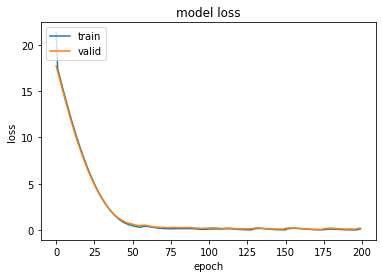

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 38.4752 - accuracy: 0.6044 - val_loss: 32.3791 - val_accuracy: 0.7778

Epoch 00001: val_accuracy improved from -inf to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.001_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 31.9207 - accuracy: 0.9206 - val_loss: 31.1813 - val_accuracy: 0.7500

Epoch 00002: val_accuracy did not improve from 0.77778
Epoch 3/200
3/3 - 0s - loss: 30.6993 - accuracy: 0.9626 - val_loss: 29.9863 - val_accuracy: 0.7500

Epoch 00003: val_accuracy did not improve from 0.77778
Epoch 4/200
3/3 - 0s - loss: 29.4913 - accuracy: 0.9907 - val_loss: 28.8012 - val_accuracy: 0.7500

Epoch 00004: val_accuracy did not improve from 0.77778
Epoch 5/200
3/3 - 0s - loss: 28.3002 - accuracy: 0.9938 - val_loss: 27.6132 - val_accuracy: 0.7778

Epoch 00005: val_accuracy did not improve from 0.77778
Epoch 6/200
3/3 - 0s - loss: 27.1217 - accuracy: 0.9938 - val_loss: 26.4265 - val_accuracy: 0.8333

Epoch 00006: val_accuracy impro

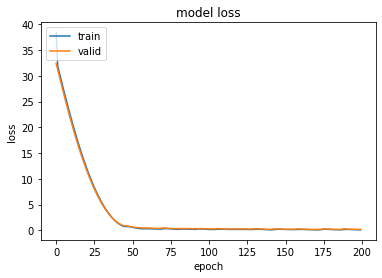

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 38.6822 - accuracy: 0.6028 - val_loss: 32.5231 - val_accuracy: 0.7778

Epoch 00001: val_accuracy improved from -inf to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.001_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 32.0624 - accuracy: 0.9206 - val_loss: 31.3164 - val_accuracy: 0.7500

Epoch 00002: val_accuracy did not improve from 0.77778
Epoch 3/200
3/3 - 0s - loss: 30.8321 - accuracy: 0.9626 - val_loss: 30.1126 - val_accuracy: 0.7500

Epoch 00003: val_accuracy did not improve from 0.77778
Epoch 4/200
3/3 - 0s - loss: 29.6155 - accuracy: 0.9907 - val_loss: 28.9054 - val_accuracy: 0.7639

Epoch 00004: val_accuracy did not improve from 0.77778
Epoch 5/200
3/3 - 0s - loss: 28.4161 - accuracy: 0.9938 - val_loss: 27.7094 - val_accuracy: 0.7917

Epoch 00005: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.001_l2_0.001.hdf5
Epoch 6/200
3/3 - 0s - loss: 27.2297

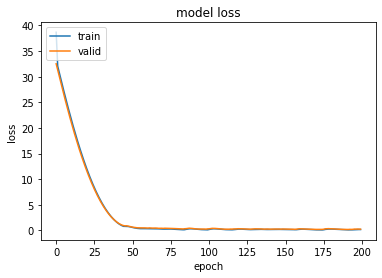

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 40.3384 - accuracy: 0.6028 - val_loss: 33.6751 - val_accuracy: 0.7778

Epoch 00001: val_accuracy improved from -inf to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.001_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 33.1955 - accuracy: 0.9190 - val_loss: 32.3963 - val_accuracy: 0.7500

Epoch 00002: val_accuracy did not improve from 0.77778
Epoch 3/200
3/3 - 0s - loss: 31.8937 - accuracy: 0.9626 - val_loss: 31.1230 - val_accuracy: 0.7500

Epoch 00003: val_accuracy did not improve from 0.77778
Epoch 4/200
3/3 - 0s - loss: 30.6081 - accuracy: 0.9907 - val_loss: 29.8493 - val_accuracy: 0.7639

Epoch 00004: val_accuracy did not improve from 0.77778
Epoch 5/200
3/3 - 0s - loss: 29.3427 - accuracy: 0.9938 - val_loss: 28.5897 - val_accuracy: 0.8056

Epoch 00005: val_accuracy improved from 0.77778 to 0.80556, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.001_l2_0.005.hdf5
Epoch 6/200
3/3 - 0s - loss: 28.0931

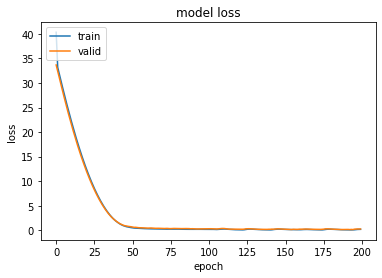

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 190.3981 - accuracy: 0.5561 - val_loss: 159.7582 - val_accuracy: 0.6389

Epoch 00001: val_accuracy improved from -inf to 0.63889, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.0005.hdf5
Epoch 2/200
3/3 - 0s - loss: 157.8394 - accuracy: 0.7991 - val_loss: 152.9883 - val_accuracy: 0.7778

Epoch 00002: val_accuracy improved from 0.63889 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.0005.hdf5
Epoch 3/200
3/3 - 0s - loss: 151.0781 - accuracy: 0.8754 - val_loss: 146.3597 - val_accuracy: 0.7917

Epoch 00003: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.0005.hdf5
Epoch 4/200
3/3 - 0s - loss: 144.4639 - accuracy: 0.9268 - val_loss: 139.8678 - val_accuracy: 0.8333

Epoch 00004: val_accuracy improved from 0.79167 to 0.83333, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2

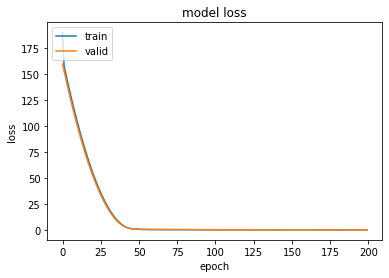

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 190.6051 - accuracy: 0.5545 - val_loss: 159.9017 - val_accuracy: 0.6389

Epoch 00001: val_accuracy improved from -inf to 0.63889, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.001.hdf5
Epoch 2/200
3/3 - 0s - loss: 157.9805 - accuracy: 0.7991 - val_loss: 153.1226 - val_accuracy: 0.7778

Epoch 00002: val_accuracy improved from 0.63889 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.001.hdf5
Epoch 3/200
3/3 - 0s - loss: 151.2100 - accuracy: 0.8754 - val_loss: 146.4851 - val_accuracy: 0.7917

Epoch 00003: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.001.hdf5
Epoch 4/200
3/3 - 0s - loss: 144.5871 - accuracy: 0.9252 - val_loss: 139.9849 - val_accuracy: 0.8333

Epoch 00004: val_accuracy improved from 0.79167 to 0.83333, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.

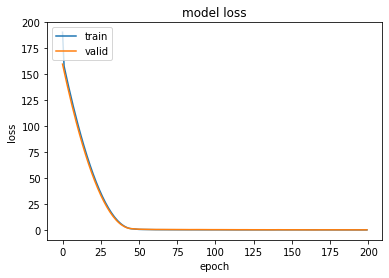

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch 1/200
3/3 - 3s - loss: 192.2612 - accuracy: 0.5545 - val_loss: 161.0501 - val_accuracy: 0.6389

Epoch 00001: val_accuracy improved from -inf to 0.63889, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.005.hdf5
Epoch 2/200
3/3 - 0s - loss: 159.1094 - accuracy: 0.7975 - val_loss: 154.1967 - val_accuracy: 0.7778

Epoch 00002: val_accuracy improved from 0.63889 to 0.77778, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.005.hdf5
Epoch 3/200
3/3 - 0s - loss: 152.2655 - accuracy: 0.8754 - val_loss: 147.4887 - val_accuracy: 0.7917

Epoch 00003: val_accuracy improved from 0.77778 to 0.79167, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.005.hdf5
Epoch 4/200
3/3 - 0s - loss: 145.5731 - accuracy: 0.9221 - val_loss: 140.9218 - val_accuracy: 0.8333

Epoch 00004: val_accuracy improved from 0.79167 to 0.83333, saving model to parameter_setting/weights_group_filters_2_units_300_l1_0.005_l2_0.

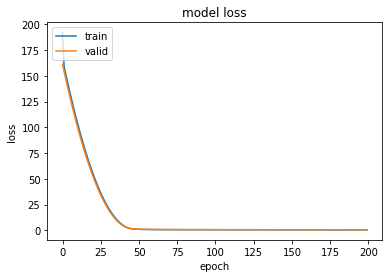

CNN train/validation Done!!!

Time for CNN training and validation: 1663.8638920783997


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [6]:
# network fitting
#-------------------------------------------------------------------------------
start = time()
for hu in range(len(n_unit)):# loop across number of units
    for l1_p in range(len(l1_param)):# loop across l1 param
        for l2_p in range(len(l2_param)):# loop across l2 param
            #-------------------------------------------------------------------
            # define cnn network
            model = cnn_network(n_fb,Nkfeats,Ntw,40,n_filt,n_unit[hu],l1_param[l1_p],l2_param[l2_p],learning_rate,sbj)
            #------------------------------------------------------------------- 
            # checkpoint
            filepath   ='parameter_setting/weights_group_filters_'+str(n_filt)+'_units_'+str(n_unit[hu])+'_l1_'+str(l1_param[l1_p])+'_l2_'+str(l2_param[l2_p])+'.hdf5'
            checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
            #-------------------------------------------------------------------
            # Fit the CNN model
            history = model.fit(XT_train_group_fT, y_train_group_fT, 
                                  epochs=200, 
                                  batch_size=256, 
                                  validation_data=(XT_valid_group_fT,y_valid_group_fT),
                                  callbacks=[checkpoint, keras.callbacks.EarlyStopping(patience=200,restore_best_weights=True)],verbose=2)
            #-------------------------------------------------------------------
            # Predict model and confusion matrix
            model.load_weights(filepath)
            y_test_pred = model.predict(XT_test_group_fT)
            y_test_pred = np.argmax(y_test_pred, axis=1)
            y_test1     = np.argmax(y_test_group_fT,axis=1)
            AccV        = 1-mean_squared_error(y_test1,y_test_pred)
            kappaV      = cohen_kappa_score(y_test1, y_test_pred, labels=None, weights=None)
            #-------------------------------------------------------------------   
            # plot loss performance    
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'valid'], loc='upper left')
            plt.show()
            #-------------------------------------------------------------------
            with open('parameter_setting/tr_vld_loss_group_units_'+str(n_unit[hu])+'_l1_'+str(l1_param[l1_p])+'_l2_'+str(l2_param[l2_p])+'.pickle', 'wb') as f:
              pickle.dump([history.history['loss'], history.history['val_loss']], f)      
            #-------------------------------------------------------------------
            del model
            #-------------------------------------------------------------------
            acc_test.append([sbj,
                            n_filt,
                            n_unit[hu],
                            l1_param[l1_p],
                            l2_param[l2_p],
                            AccV*100, 
                            kappaV])
            sio.savemat('results/Group.mat',{'Acc':acc_test})
            #-------------------------------------------------------------------
print('CNN train/validation Done!!!\n')
print('Time for CNN training and validation:', time()-start)
#-------------------------------------------------------------------------------

# Auxiliar definition

In [7]:
# definitions
#-------------------------------------------------------------------------------
def min_dist(X):
    p1       = [100.0,1.0]
    distance = []
    for i in range(len(X)):
        p2 = X[i,:]
        distance.append(math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) ))
    min_id = np.argmin(distance) 
    return distance, min_id
#-------------------------------------------------------------------------------

# Cuantitative results (classification performance on test set)

In [8]:
#-------------------------------------------------------------------------------
Nsbj        = 'Group'
n_fb        = 2
num_classes = 2
print('Subject '+str(Nsbj))
# load rithms data--------------------------------------------------------------
data = sio.loadmat('results/'+str(Nsbj)+'.mat')
data = data['Acc']
X    = data[:,data.shape[1]-2:data.shape[1]]
print(X)
#-------------------------------------------------------------------------------    
# select best performance-------------------------------------------------------
distance, min_id = min_dist(X)
max_id           = min_id
opt_neurons      = data[max_id,data.shape[1]-5]
opt_l1           = data[max_id,data.shape[1]-4][0][0]
opt_l2           = data[max_id,data.shape[1]-3][0][0]
print('Group - acc: ' +str(X[max_id,0][0][0])+ '- Kappa value: '+str(X[max_id,1][0][0])+
      ' neurons '+str(int(opt_neurons))+ ' l1_val '+str(opt_l1)+ ' l2_val '+str(opt_l2))
#-------------------------------------------------------------------------------

Subject Group
[[array([[86.25]]) array([[0.72396487]])]
 [array([[88.75]]) array([[0.775]])]
 [array([[87.5]]) array([[0.74984365]])]
 [array([[82.5]]) array([[0.64934252]])]
 [array([[88.75]]) array([[0.775]])]
 [array([[88.75]]) array([[0.775]])]
 [array([[93.75]]) array([[0.87515605]])]
 [array([[88.75]]) array([[0.7747184]])]
 [array([[88.75]]) array([[0.7747184]])]
 [array([[87.5]]) array([[0.75046787]])]
 [array([[88.75]]) array([[0.7747184]])]
 [array([[85.]]) array([[0.70018738]])]
 [array([[81.25]]) array([[0.62453066]])]
 [array([[88.75]]) array([[0.7752809]])]
 [array([[92.5]]) array([[0.85028072]])]
 [array([[87.5]]) array([[0.74984365]])]
 [array([[86.25]]) array([[0.72431078]])]
 [array([[88.75]]) array([[0.7747184]])]
 [array([[85.]]) array([[0.69943644]])]
 [array([[87.5]]) array([[0.74984365]])]
 [array([[83.75]]) array([[0.67418546]])]
 [array([[90.]]) array([[0.80012492]])]
 [array([[86.25]]) array([[0.72465582]])]
 [array([[87.5]]) array([[0.74984365]])]
 [array([[8

# Qualitative results (Interpretability of results according relevant brain areas)
- Optimized spatial representations that highlights the most contributing information in all domains (Type of EEG representation, filter band and time window.)

In [9]:
#-------------------------------------------------------------------------------
def hidden_layer_results(hidden_layer,shape_im):
    weights, biases = hidden_layer.get_weights()    
    tmp0            = np.sum(np.abs(weights),axis=1)
    n_filters       = np.int(tmp0.shape[0]/(shape_im[0]*shape_im[1]))
    im              = [] 
    for i in range(n_filters):
        image = []
        j     = 0 + i
        while j < tmp0.shape[0]:
            image.append(tmp0[j])
            j = j+(n_filters)
        image = np.array(image)
        im.append(image.reshape((shape_im)))
    im  = np.array(im)
    # average according frequency bands
    vec_t = np.arange(0,im.shape[0],2)
    imF   = []
    for l in range(len(vec_t)):
        if l == len(vec_t)-1:
            imF.append(np.mean(im[vec_t[l]:im.shape[0],:,:],axis=0))
        else:
            imF.append(np.mean(im[vec_t[l]:vec_t[l+1],:,:],axis=0))
    imF = np.array(imF)
    return imF
#-------------------------------------------------------------------------------

Subject Group
[0, 1, 10, 11]
[2, 3, 12, 13]
[4, 5, 14, 15]
[6, 7, 16, 17]
[8, 9, 18, 19]
max_val 0.06327201
new_max_val 1.0
min_val 0.013957787


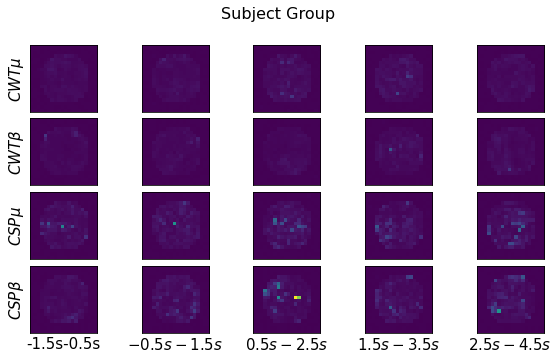

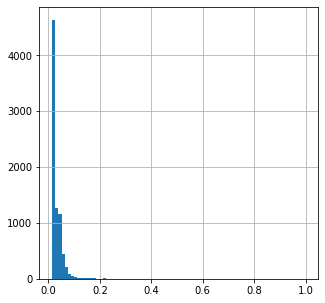

In [10]:
#-------------------------------------------------------------------------------
names_x  = [r'-1.5s-0.5s',r'$-0.5s-1.5s$',r'$0.5s-2.5s$',r'$1.5s-3.5s$',r'$2.5s-4.5s$']
Ntw      = 5
n_fb     = 2
Nkfeats  = 2
hist     = []
print('Subject '+str(Nsbj))
# figure plot setting-----------------------------------------------------------
fig, axs = plt.subplots(4,5,figsize=(10,5.3))
fig.subplots_adjust(hspace = 0.1, wspace=.0001)
#-------------------------------------------------------------------------------
# Describe CNN model------------------------------------------------------------
model = cnn_network(n_fb,Nkfeats,Ntw,40,n_filt,opt_neurons,opt_l1,opt_l2,learning_rate,Nsbj)
#-------------------------------------------------------------------------------
# plot topographic maps---------------------------------------------------------
topo_avg_mu_cwt = []
topo_avg_be_cwt = []
topo_avg_mu_csp = []
topo_avg_be_csp = []
for tw in range(Ntw):
  if tw == 0:
    ids_tw = [tw, tw+1, tw+10, tw+10+1] 
  else:
    ids_tw = [tw*2, tw*2+1, tw*2+10, tw*2+10+1]
  print(ids_tw)
  XT_mu_cwt = []
  XT_be_cwt = []
  XT_mu_csp = []
  XT_be_csp = []
  #-----------------------------------------------------------------------------
  filepath        = 'parameter_setting/weights_group_filters_2_units_'+str(int(opt_neurons))+'_l1_'+str(opt_l1)+'_l2_'+str(opt_l2)+'.hdf5'
  checkpoint_path = filepath
  model.load_weights(checkpoint_path)
  #-----------------------------------------------------------------------------  
  # Hidden layer results
  hidden_layer = model.layers[83]
  shape_im     = model.layers[79].output_shape[1:3]
  im_mean      = hidden_layer_results(hidden_layer,shape_im)
  #-----------------------------------------------------------------------------    
  # standarsize and normalize
  x_mu_cwt   = np.array(im_mean[ids_tw[0],:,:])
  x_beta_cwt = np.array(im_mean[ids_tw[1],:,:])
  x_mu_csp   = np.array(im_mean[ids_tw[2],:,:])
  x_beta_csp = np.array(im_mean[ids_tw[3],:,:])
  #-----------------------------------------------------------------------------
  topo_avg_mu_cwt.append(np.array(x_mu_cwt))
  topo_avg_be_cwt.append(np.array(x_beta_cwt))
  topo_avg_mu_csp.append(np.array(x_mu_csp))
  topo_avg_be_csp.append(np.array(x_beta_csp))
  #-----------------------------------------------------------------------------
topo_avg_muT_cwt = np.array(topo_avg_mu_cwt)
topo_avg_beT_cwt = np.array(topo_avg_be_cwt)
topo_avg_muT_csp = np.array(topo_avg_mu_csp)
topo_avg_beT_csp = np.array(topo_avg_be_csp)
#-------------------------------------------------------------------------------
max_val = max(topo_avg_muT_cwt.max(),topo_avg_beT_cwt.max(),topo_avg_muT_csp.max(),topo_avg_beT_csp.max())
print('max_val',max_val)
#-------------------------------------------------------------------------------
topo_avg_muT_cwt = topo_avg_muT_cwt / max_val 
topo_avg_beT_cwt = topo_avg_beT_cwt / max_val 
topo_avg_muT_csp = topo_avg_muT_csp / max_val 
topo_avg_beT_csp = topo_avg_beT_csp / max_val
#-------------------------------------------------------------------------------
max_val = max(topo_avg_muT_cwt.max(),topo_avg_beT_cwt.max(),topo_avg_muT_csp.max(),topo_avg_beT_csp.max())
print('new_max_val',max_val)
#-------------------------------------------------------------------------------
min_val = min(topo_avg_muT_cwt.min(),topo_avg_beT_cwt.min(),topo_avg_muT_csp.min(),topo_avg_beT_csp.min())
print('min_val',min_val)
#-------------------------------------------------------------------------------
for vnt in range(Ntw):
    axs[0,vnt].imshow(topo_avg_muT_cwt[vnt,:,:],vmin=min_val, vmax=max_val)
    axs[1,vnt].imshow(topo_avg_beT_cwt[vnt,:,:],vmin=min_val, vmax=max_val)
    axs[2,vnt].imshow(topo_avg_muT_csp[vnt,:,:],vmin=min_val, vmax=max_val)
    axs[3,vnt].imshow(topo_avg_beT_csp[vnt,:,:],vmin=min_val, vmax=max_val)
    axs[3,vnt].set(xlabel=names_x[vnt])
    axs[3,vnt].xaxis.get_label().set_fontsize(15)
    if vnt == 0:
       axs[0,vnt].set(ylabel=r'$CWT \mu$')
       axs[0,vnt].yaxis.get_label().set_fontsize(15)
       axs[1,vnt].set(ylabel=r'$CWT \beta$')
       axs[1,vnt].yaxis.get_label().set_fontsize(15)
       axs[2,vnt].set(ylabel=r'$CSP \mu$')
       axs[2,vnt].yaxis.get_label().set_fontsize(15)
       axs[3,vnt].set(ylabel=r'$CSP \beta$')
       axs[3,vnt].yaxis.get_label().set_fontsize(15)
    fig.suptitle('Subject '+str(Nsbj), fontsize=16)

    # hist
    hist.append(topo_avg_muT_cwt[vnt,:,:].flatten())
    hist.append(topo_avg_beT_cwt[vnt,:,:].flatten())
    hist.append(topo_avg_muT_csp[vnt,:,:].flatten())
    hist.append(topo_avg_beT_csp[vnt,:,:].flatten())
#-------------------------------------------------------------------------------
for ax in axs.flat:
    ax.label_outer()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig('results/Topoplots_Subject_'+str(Nsbj)+'T.svg', format='svg')
#-------------------------------------------------------------------------------
#plot histograms
hist = np.concatenate(hist)
hist = hist.flatten()
plt.figure(figsize=(5,5))
plt.hist(hist,bins=80)
plt.grid()
#-------------------------------------------------------------------------------

**NOTE:**
- The files of optimal model, the performance file, and the figures can be downloaded from current session COLAB.

# Download data

In [11]:
#from google.colab import files
#files.download('/content/parameter_setting/weights_sbj_'+str(sbj)+'_filters_'+str(n_filt)+'_units_'+str(int(opt_neurons))+'_l1_'+str(opt_l1)+'_l2_'+str(opt_l2)+'.hdf5') 

In [12]:
#from google.colab import files
#files.download('/content/parameter_setting/tr_vld_loss_sbj_'+str(sbj)+'_units_'+str(int(opt_neurons))+'_l1_'+str(opt_l1)+'_l2_'+str(opt_l2)+'.pickle') 

In [13]:
#from google.colab import files
#files.download('/content/train_valid_idxs/tr_vld_idxs_sbj_'+str(sbj)+'.pickle') 

In [14]:
#from google.colab import files
#files.download('/content/results/Topoplots_Subject_'+str(Nsbj)+'T.svg') 